In [1]:
import math
import main
import random
import tikzplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, cm, colors
from scipy.spatial import distance
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

Generate distribution of ellipses

In [2]:
## generate distribution
grid = np.array([1000, 1000])
width, height = grid
m = 2       # number of starting points
N = 1028    # number of all points
r_min = 4   # minimum distance between spheres

## Selects two random points on a grid
initial = np.array([ [random.uniform(0,1)*width, random.uniform(0,1)*height] for i in range(m) ])
## and generate distribution with Mitchell algorithm
dist = main.distribution(initial, grid, N)

In [3]:
## change circles into ellipses
a, eps = 5, math.sqrt(21)/5     # big semi-axis and eccentricity
b = a*math.sqrt(1-eps**2)       # small semi-axis
a_width, b_height = 2*a, 2*b    # small and big semi-axis for patches

new_dist = main.ellipses(dist, a, b)

(0.0, 1000.0)

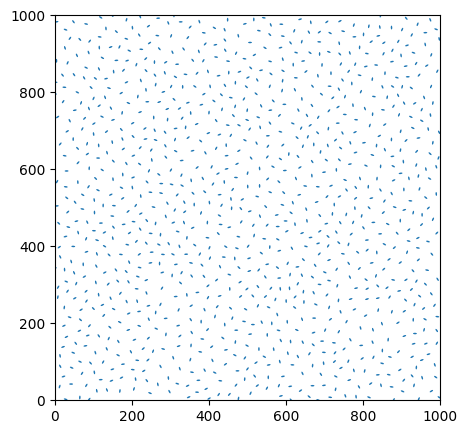

In [4]:
## generate ellipses
plt.figure(figsize=(5,5))

for center in new_dist.ell:
    ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ellipse)

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
# plt.savefig("elipse_512.png")

# tikzplotlib.save("test.tex")

Enlarge and rotate the ellipses

In [5]:
def change_size(a_range):
    ## change b
    b_range = a_range*math.sqrt(1-eps**2)
    a_width, b_height = 2*a_range, 2*b_range

    new_dist.a = a_range
    new_dist.b = b_range

    ## generate ellipses
    plt.figure(figsize=(6,6))

    for center in new_dist.ell:
        ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
        plt.gca().add_patch(ellipse)

    plt.axis('scaled')
    plt.xlim(0.0, width)
    plt.ylim(0.0, height)
    # plt.savefig("elipse_512.png")
    plt.show()

In [9]:
from ipywidgets import FloatSlider, interact, link

slider = FloatSlider(min=0, max=20, step=0.1, value=new_dist.a)
interact(change_size, a_range=slider)

interactive(children=(FloatSlider(value=10.0, description='a_range', max=20.0), Output()), _dom_classes=('widg…

<function __main__.change_size(a_range)>

In [10]:
## update a in matrices A
new_dist.fix_A

## distance matrix between all the centres
S = [x.center for x in new_dist.ell]
distance_matrix = distance.cdist(S, S, dist.periodic_metric)

## matrix of indices of neighbouring ellipses, which are less than 2*a apart
in_proximity = [np.where((line<=2*new_dist.a) & (line!=0)) for line in distance_matrix]

In [11]:
import cProfile
cProfile.run("new_dist.metropolis(in_proximity, n=100)")

         29349972 function calls (28133754 primitive calls) in 29.725 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(copyto)
      185    0.000    0.000    0.003    0.000 <__array_function__ internals>:177(diag)
  1203000    0.779    0.000    3.849    0.000 <__array_function__ internals>:177(dot)
   607515    0.389    0.000    9.470    0.000 <__array_function__ internals>:177(inv)
     2231    0.004    0.000    0.055    0.000 <__array_function__ internals>:177(sum)
     2433    0.005    0.000    0.012    0.000 <__array_function__ internals>:177(where)
        1    0.000    0.000   29.725   29.725 <string>:1(<module>)
  1287/99    0.003    0.000    0.007    0.000 copy.py:128(deepcopy)
      891    0.000    0.000    0.000    0.000 copy.py:182(_deepcopy_atomic)
       99    0.001    0.000    0.004    0.000 copy.py:227(_deepcopy_dict)
      396   

In [13]:
## *do the magic*
Energy, coord_number, accepted, rejected = new_dist.metropolis(in_proximity, n=1000)

In [14]:
## let's have fun with colours --> map energy values to color palette
my_palette = LinearSegmentedColormap.from_list('custom red', ["#577590", "#f94144", "#f8961e"], N=256)
# my_palette = LinearSegmentedColormap.from_list('custom red', ["#ffffff", "#ff0a54"], N=256)

## heatmap of energy
minima = np.round(np.min(Energy), 2)
maxima = np.round(np.max(Energy), 2)

## heatmap of coordination number
# minima = np.round(np.min(coord_number), 2)
# maxima = np.round(np.max(coord_number), 2)

norm = colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=my_palette)

/tmp/ipykernel_119297/2738903161.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mapper, ticks=cbar, shrink=0.85, orientation='vertical')


(0.0, 1000.0)

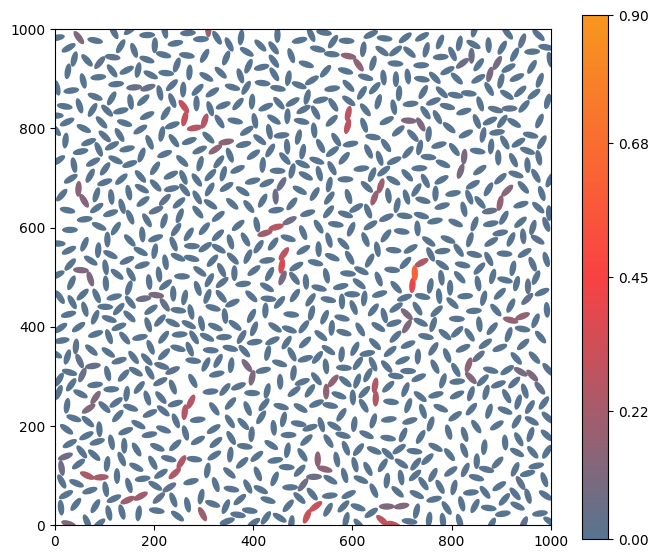

In [15]:
plt.figure(figsize=(8,8))

## dimensions for patches
a_width, b_height = 2*new_dist.a, 2*new_dist.b

for center in new_dist.ell:
    index = np.where(new_dist.ell == center)
    v = Energy[-1,index]
    # v = coord_number[-1,index]

    ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ellipse)
    ellipse.set_facecolor(mapper.to_rgba(v)[0])
    ellipse.set_label('_nolegend_')

cbar = np.round( np.linspace(minima, maxima, 5, endpoint=True), 2)
plt.colorbar(mapper, ticks=cbar, shrink=0.85, orientation='vertical')

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)

# tikzplotlib.save("test.tex")

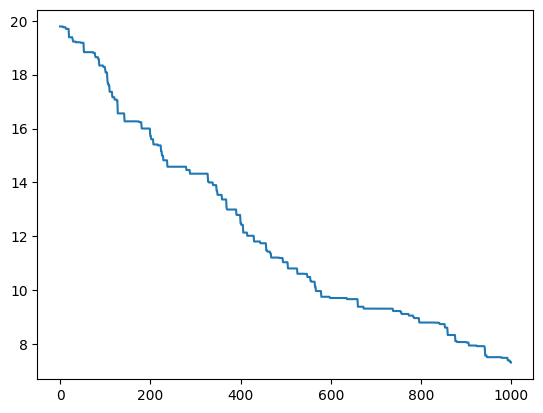

In [16]:
## check parametres
x = np.arange(len(Energy[:,0]))

## E = 1/2*u_i ---> 2x štejemo vse pare
y = 0.5*np.sum(Energy, axis=1)
plt.plot(x, y)
plt.show()

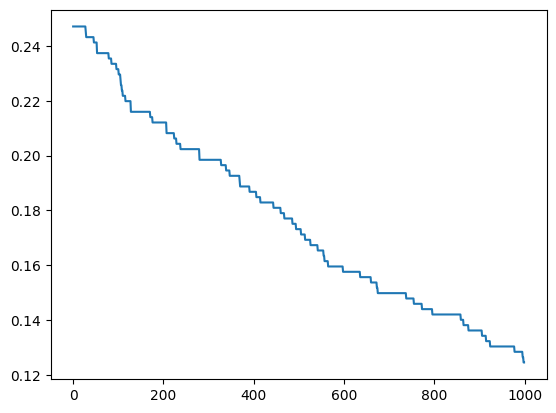

In [17]:
## Coordination numbers
x = np.arange(len(coord_number[:,0]))

## Z for one ellipse
plt.plot(x, np.sum(coord_number, axis=1)/len(coord_number[0,:]))
plt.show()

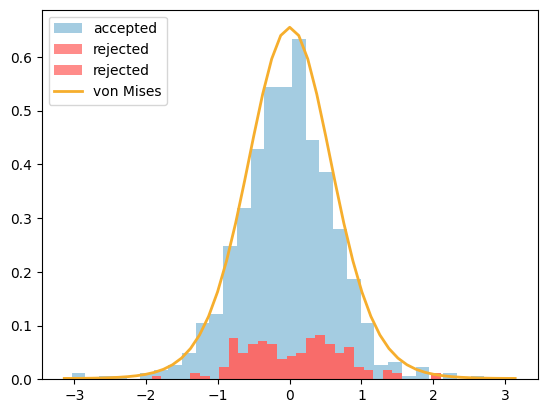

In [19]:
## histograms that have to be normalised
from scipy.special import i0


hist1, bins1 = np.histogram(accepted[~np.isnan(accepted)], bins=30)
hist2, bins2 = np.histogram(rejected[~np.isnan(rejected)], bins=30)

norm = np.sum(hist1*np.diff(bins1)) + np.sum((hist2)*np.diff(bins2))
wgt = [np.ones_like(accepted)/norm, np.ones_like(rejected)/norm]

plt.hist(accepted, bins=bins1, facecolor='#86BBD8', weights=wgt[0], alpha=0.75, label='accepted')
plt.hist(rejected, bins=bins2, facecolor='#FF6663', weights=wgt[1], alpha=0.75, label='rejected')

plt.hist(rejected, bins=bins2, facecolor='#FF6663', weights=wgt[1], alpha=0.75, label='rejected')
mu, kappa = 0, 3
x = np.linspace(-math.pi, math.pi, num=51)
y = np.exp(kappa*np.cos(x-mu))/(2*np.pi*i0(kappa))
plt.plot(x, y, linewidth=2, color='#F6AE2D', label='von Mises')
plt.legend(loc='upper left')

plt.show()

In [20]:
## Calculate the correlation function
r = np.linspace(1, 3, 100)
y = new_dist.angle_correlation(r*new_dist.a)

TypeError: distribution.periodic_metric() missing 1 required positional argument: 'point2'

ValueError: x and y must have same first dimension, but have shapes (100,) and (51,)

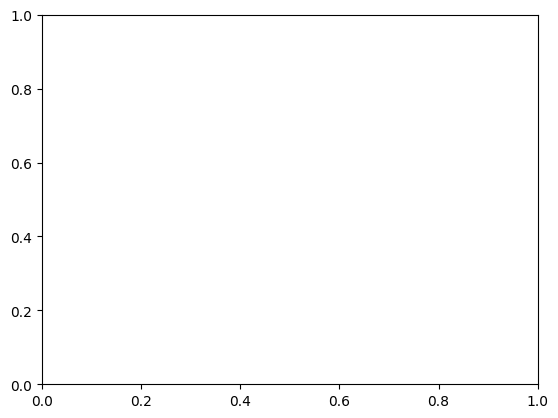

In [21]:
plt.plot(r, y, linewidth=2, color='r')

plt.xscale('log')
plt.xticks([1, 2, 3], [1, 2, 3])

plt.xlabel('r/a')
plt.ylabel('g_2 (r)')
plt.show()